# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: `Коротков Михаил`

Группа: `MADE-DS-12`

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

In [280]:
# put your code here

#1 просто генерим точки и проверяем
#2 пошаговая оптимизация каждой координаты. Сначала ищем долготу, при которой расстояние до полигона минимально. 
# Затем, для этой долготы ищем оптимальную гироту аналогично

import geopandas as gpd
import folium
from shapely.geometry import Point, Polygon
import random
import numpy as np

In [282]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
poly = world[world['CODE']=='AFG'].loc[103]['geometry']

Часть 1

In [283]:
def generate_point():
    lat = random.uniform(-90, 90)
    lon = random.uniform(-180, 180)
    return Point(lon, lat)

m = folium.Map(
    location=[33.372, 66.6972],
    zoom_start=1,
    tiles='Stamen Terrain'
)
tooltip = 'Click me!'
while 1:
    p = generate_point()
    if poly.contains(p):
        folium.Marker([p.y, p.x], popup='<i>RESULT</i>', tooltip=tooltip, icon=folium.Icon(color='red')).add_to(m)
        break
    else:
        folium.Marker([p.y, p.x], popup='<i>NOT A RESULT</i>', tooltip=tooltip, icon=folium.Icon(color='blue')).add_to(m)

In [284]:
m

Часть 2
Каждая новая точка алгоритма обозначена кругом, итоговая - иконкой.
Размер круга для нагляднсти обратнопропорционален расстоянию до центра Афганистана.

Алгоритм предусматривает последновательный поиск оптимальной долготы и широты. 
Для этого сравниваются расстояния от трех точек до центра Афганистана и далее из них выбираеются 2 ближайшие, а третья точка заменяется на точку между лучшими двумя. Фактически это бинпоиск сначала по долготе, а затем по широте.

In [286]:
eps = 0.01

def find_lat(p_new, p1, p2, poly, eps):
    folium.CircleMarker([p_new.y, p_new.x], popup='<i>p_new</i>', color = 'green', fill=True, tooltip=tooltip, radius=200/(p_new.distance(poly.centroid))).add_to(m)
#     k1 += 10
    d_new = p_new.distance(poly.centroid)
    d1 = p1.distance(poly.centroid)
    d2 = p2.distance(poly.centroid)
#     print(d_new, d1, d2)
    if abs(d2 - d1) < eps:
        return p_new
    else:
        if d1 < d2:
            if np.sign(p1.x) != np.sign(p_new.x):
                x_new = (p_new.x + p1.x) / 2 + 180 * np.sign(-(p_new.x + p1.x))
                return find_lat(Point(x_new, p_new.y), p1, p_new, poly, eps)
            else:
                return find_lat(Point((p_new.x + p1.x) / 2, p_new.y), p1, p_new, poly, eps)
        else:
            if np.sign(p2.x) != np.sign(p_new.x):
                x_new = (p_new.x + p2.x) / 2 + 180 * np.sign(-(p_new.x + p2.x))
                return find_lat(Point(x_new, p_new.y), p2, p_new, poly, eps)
            else:
                return find_lat(Point((p_new.x + p2.x) / 2, p_new.y), p2, p_new, poly, eps)
            
                
def find_lon(p_new, p1, p2, poly, eps):
    d_new = p_new.distance(poly.centroid)
    d1 = p1.distance(poly.centroid)
    d2 = p2.distance(poly.centroid)
    
    folium.CircleMarker([p_new.y, p_new.x], popup='<i>p_new_</i>', color = 'blue', tooltip=tooltip, radius=100/(p_new.distance(poly.centroid))).add_to(m)
#     print(p_new, p1, p2)
#     print(d_new, d1, d2, p_new.contains(poly))

    if poly.contains(p_new):
        return p_new
    else:
        if d1 < d2:
            return find_lon(Point(p_new.x, ((p_new.y + p1.y) / 2)), p1, p_new, poly, eps)
        else:
            return find_lon(Point(p_new.x, ((p_new.y + p2.y) / 2)), p2, p_new, poly, eps)
    
    
    

m = folium.Map(
    location=[33.372, 66.6972],
    zoom_start=1,
    tiles='Stamen Terrain'
)

tooltip = 'Click me!'
p1 = Point(30, 0)

if p1.x > 60:
    x_ = p1.x - 120
    x__ = p1.x - 240
elif p1.x < -60:
    x_ = p1.x + 120
    x__ = p1.x + 240
else:
    x_ = p1.x + 120
    x__ = p1.x - 120
    
p2 = Point(x_, p1.y)
p3 = Point(x__, p1.y)


folium.CircleMarker([p1.y, p1.x], popup='<i>p1</i>', color = 'green', fill=True, tooltip=tooltip, radius=200/(p1.distance(poly.centroid))).add_to(m)
folium.CircleMarker([p2.y, p2.x], popup='<b>p2</b>', color = 'green', tooltip=tooltip, fill=True, radius=200/(p2.distance(poly.centroid))).add_to(m)
folium.CircleMarker([p3.y, p3.x], radius=200/(p3.distance(poly.centroid)), popup='<b>p3</b>', color = 'green', fill=True, tooltip=tooltip).add_to(m)

d1 = p1.distance(poly.centroid)
d2 = p2.distance(poly.centroid)
d3 = p3.distance(poly.centroid)

# Ищем долготу с минимальным расстоянием до центра Афганистана
if d2 > d1 and d2 > d3:
    if np.sign(p1.x + p3.x):
        p2 = Point((p1.x + p3.x) / 2 - 180, p2.y)
    else:
        p2 = Point((p1.x + p3.x) / 2 + 180, p2.y)
    la_t = find_lat(p2, p1, p3, poly, eps)
elif d1 > d2 and d1 > d3:
    p1 = Point((p2.x + p3.x) / 2, p1.y)
    la_t = find_lat(p1, p2, p3, poly, eps)
else:
    p3 = Point((p1.x + p2.x) / 2, p3.y)
    la_t = find_lat(p3, p1, p2, poly, eps)
   
p1_ = la_t
p2_ = Point(p1_.x, -90)
p3_ = Point(p1_.x, 90)

folium.CircleMarker([p2_.y, p2_.x], popup='<i>p2_</i>', color = 'blue', tooltip=tooltip, radius=100/(p2_.distance(poly.centroid))).add_to(m)
folium.CircleMarker([p3_.y, p3_.x], popup='<i>p3_</i>', color = 'blue', tooltip=tooltip, radius=100/(p3_.distance(poly.centroid))).add_to(m)

# Ищем широту
poi = find_lon(p1_, p2_, p3_, poly, eps)

# Рисуем итоговую точку
folium.Marker([poi.y, poi.x], popup='<i>RESULT</i>', tooltip=tooltip, icon=folium.Icon(color='red')).add_to(m)

In [287]:
m

Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

In [1]:
import pandas as pd
capitals = pd.read_csv('capitals.txt')
capitals = capitals[['country', 'capital']]
capitals['mapped'] = capitals['capital'] + ', ' + capitals['country']
list_capitals = list(capitals['mapped'])
list_capitals.append('London, UK')

In [2]:
# cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
nominatim = Nominatim()

К сожалению, ноутбук по памяти не вытягивал аналогичный запрос по стране, поэтому 
для пункта 1 вместо страны с наибольшим количеством объектов жилой недвижимости я искал 
страну с наибольшим количеством объектов жилой недвижимости в столице.

Надеюсь, что такое изменение условия не является критичным и не меняет смысла задания

In [3]:
count_buildings = []
overpass = Overpass()
for capital in list_capitals:
    areaId = nominatim.query(capital).areaId()
    print(capital, areaId)
    if areaId:
        tmp = 0
        for b_type in ['apartments', 'bungalow', 'detached', 'cabin', 'farm', 'dormitory', 'ger', 'hotel', 'house', 'houseboat', 
                       'residential', 'semidetached_house', 'static_caravan', 'terrace']:
            query = overpassQueryBuilder(area=areaId, elementType=['node', 'way', 'relation'], selector="building="+b_type, out='count')
            result = overpass.query(query, timeout = 500)
            tmp += result.countElements()
        add = {
            'capital': capital,
            'areaId': areaId,
            'result': tmp
        }
        count_buildings.append(add)
        print(tmp, '\n')

Sukhumi, Abkhazia 3602027324
927 

Kabul, Afghanistan 3601676476
0 

Episkopi Cantonment, Akrotiri and Dhekelia None
Tirana, Albania 3601250106
1300 

Algiers, Algeria 3600192756
100954 

Pago Pago, American Samoa 3600253733
29 

Andorra la Vella, Andorra 3603657693
32 

Luanda, Angola 3601802546
53139 

The Valley, Anguilla None
St. John's, Antigua and Barbuda None
Buenos Aires, Argentina 3601224652
4161 

Yerevan, Armenia 3600364087
10058 

Oranjestad, Aruba None
Georgetown, Ascension Island None
Canberra, Australia None
Vienna, Austria 3600109166
24092 

Baku, Azerbaijan 3603764541
1810 

Nassau, Bahamas None
Manama, Bahrain None
Dhaka, Bangladesh 3603921322
20519 

Bridgetown, Barbados 3607751694
4 

Minsk, Belarus 3600059195
11494 

Brussels, Belgium 3602404021
180 

Belmopan, Belize 3610331791
368 

Porto-Novo, Benin 3602945791
1903 

Hamilton, Bermuda 3603644277
13 

Thimphu, Bhutan 3609330372
385 

Sucre, Bolivia None
La Paz, Bolivia 3604499870
2242 

Sarajevo, Bosnia and Herze

1344 

Tashkent, Uzbekistan 3602216724
10354 

Port Vila, Vanuatu None
Vatican City, Vatican City 3608038348
1 

Caracas, Venezuela 3611219583
4164 

Hanoi, Vietnam 3601903516
3685 

Cardiff, Wales 3601625787
6360 

Mata-Utu, Wallis and Futuna None
El Aaiún, Western Sahara None
Sanaá, Yemen 3609126077
2 

Lusaka, Zambia None
Harare, Zimbabwe None
London, UK 3600065606
245753 



In [4]:
sorted(count_buildings, key=lambda x: x['result'])

[{'capital': 'Kabul, Afghanistan', 'areaId': 3601676476, 'result': 0},
 {'capital': 'West Island, Cocos (Keeling) Islands',
  'areaId': 3611716755,
  'result': 0},
 {'capital': 'Hagåtña, Guam', 'areaId': 3600253788, 'result': 0},
 {'capital': 'Tarawa, Kiribati', 'areaId': 3606634076, 'result': 0},
 {'capital': 'Valletta, Malta', 'areaId': 3607510580, 'result': 0},
 {'capital': 'Yaren, Nauru', 'areaId': 3608384066, 'result': 0},
 {'capital': 'Alofi, Niue', 'areaId': 3601558549, 'result': 0},
 {'capital': 'Taipei, Republic of China (Taiwan)',
  'areaId': 3610907761,
  'result': 0},
 {'capital': 'Marigot, Saint Martin', 'areaId': 3600288277, 'result': 0},
 {'capital': 'Funafuti, Tuvalu', 'areaId': 3603766660, 'result': 1},
 {'capital': 'Vatican City, Vatican City', 'areaId': 3608038348, 'result': 1},
 {'capital': 'Banjul, Gambia', 'areaId': 3603214211, 'result': 2},
 {'capital': 'Sanaá, Yemen', 'areaId': 3609126077, 'result': 2},
 {'capital': 'Bridgetown, Barbados', 'areaId': 3607751694, 

Итого - столица с наибольшим числом объектов жилой недвижимости - Бразилия
'Brasília, Brazil'

Выкачиваем данные о банкоматах в Бразилии

In [219]:
# areaId = 3600059470
import requests
import json
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="BR"][admin_level=2];
(node["amenity"="atm"](area);
);
out center;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()
# query = overpassQueryBuilder(area=areaId, elementType=['node', 'way', 'relation'], selector="building="+b_type, out='count')
# result = overpass.query(query, timeout = 500)

In [222]:
len(data['elements'])

1330

In [311]:
atm_data = []
for point in data['elements']:
    add = {
        'x': point['lon'],
        'y': point['lat'],
        'geometry': Point(point['lon'], point['lat'])
    }
    atm_data.append(add)

In [243]:
import osmnx as ox
ox.config(use_cache=True, log_console=True)
gdf = ox.geocode_to_gdf('Brasília, Brazil')
geometry = gdf['geometry'].iloc[0]

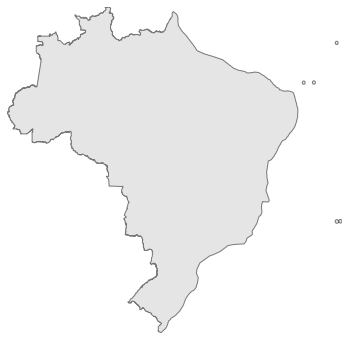

In [317]:
import matplotlib.pyplot as plt
from descartes import PolygonPatch
west, south, east, north = gdf.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)

ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [312]:
point_gdf = gpd.GeoDataFrame(atm_data)

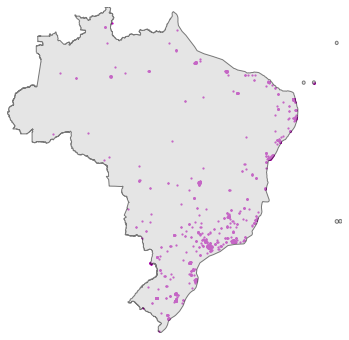

In [318]:
west, south, east, north = point_gdf.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)

ax.scatter(x=point_gdf['x'], y=point_gdf['y'], s=5, c='m', linewidth=0, zorder=1)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

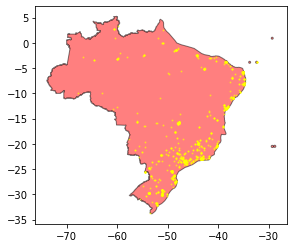

In [319]:
ax = gdf.plot(color='red', edgecolor='black', alpha=0.5)
ax = point_gdf.plot(ax=ax, color='yellow', markersize=1, alpha=0.5)

In [269]:
sp_index = point_gdf.sindex

In [273]:
# Посмотрим, что лежит в индексе
n_iterations = 10
for i, group in enumerate(sp_index.leaves()):
    group_idx, indices, bbox = group
    print("Group", group_idx, "contains ", len(indices), "geometries, bounding box:", bbox)
    i+=1
    if i == n_iterations:
        break

Group 2 contains  70 geometries, bounding box: [-33.6927926, -53.7409906, -24.0453835, -51.7933642]
Group 3 contains  70 geometries, bounding box: [-30.1170763, -51.5043768, -27.1731989, -51.1489347]
Group 0 contains  70 geometries, bounding box: [-30.8948362, -55.536289, -24.7205524, -53.7432965]
Group 4 contains  70 geometries, bounding box: [-30.2438751, -51.1489027, -24.1456693, -49.0766833]
Group 5 contains  70 geometries, bounding box: [-28.474289, -49.0716362, -23.9961868, -46.407039]
Group 8 contains  70 geometries, bounding box: [-23.976842, -46.5849301, -21.8104111, -45.4581013]
Group 7 contains  70 geometries, bounding box: [-23.7273147, -46.8798919, -21.9641128, -46.5962593]
Group 9 contains  70 geometries, bounding box: [-23.8220898, -45.4268474, -21.7709978, -43.362234]
Group 6 contains  70 geometries, bounding box: [-23.6129419, -55.7314165, -21.7902176, -46.9716968]
Group 10 contains  70 geometries, bounding box: [-23.0018347, -43.3603826, -22.3572182, -41.7710869]


Найдем k-nearest с помощью rtree spatial indexes

In [325]:
list_k_nearest = list(sp_index.nearest((poi.y, poi.y, poi.x, poi.x), 5))

In [347]:
m = folium.Map(
    location=[point_gdf.iloc[list_k_nearest[0]].y, point_gdf.iloc[list_k_nearest[0]].x],
    zoom_start=10,
    tiles='Stamen Terrain'
)

five_nearest = []
for i in range(point_gdf.shape[0]):
    if i in list_k_nearest:
        add = {
            'x': point_gdf.iloc[i]['x'],
            'y': point_gdf.iloc[i]['y'],
            'geometry': point_gdf.iloc[i]['geometry']
        }
        folium.Marker([point_gdf.iloc[i]['y'], point_gdf.iloc[i]['x']], popup='<i>RESULT</i>', tooltip=tooltip, icon=folium.Icon(color='red')).add_to(m)
        five_nearest.append(add)

five_nearest_gdf = gpd.GeoDataFrame(five_nearest)

Визуализация на карте Бразилии (Красным справа сверху)

<AxesSubplot:>

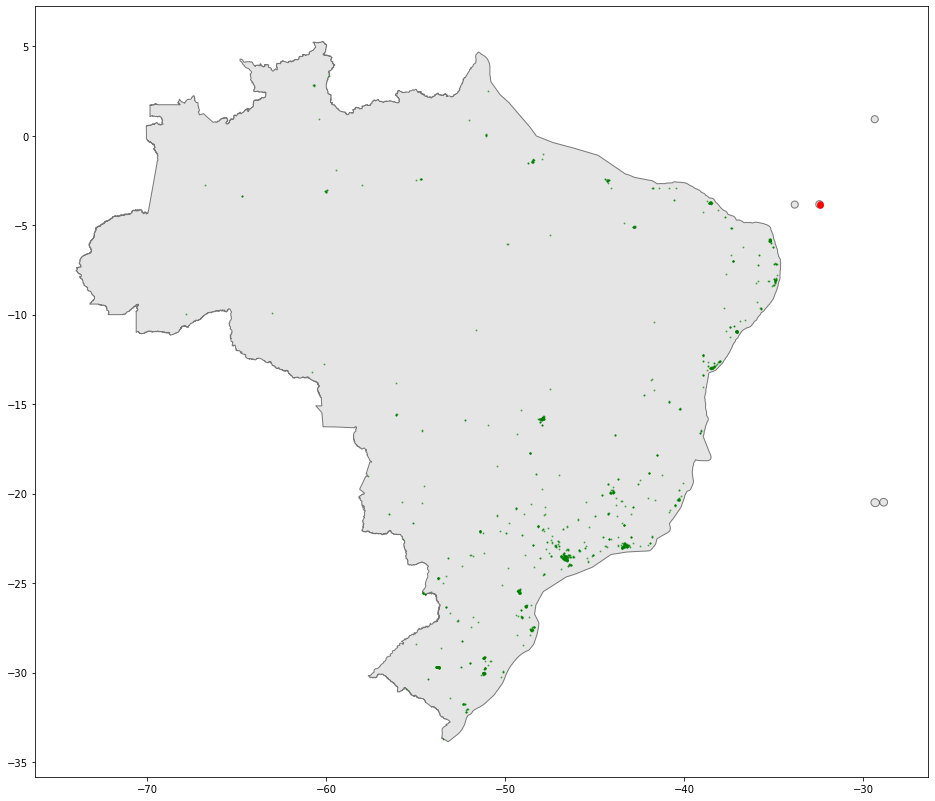

In [338]:
fig, ax = plt.subplots(figsize=(16,16))
gdf.plot(ax = ax, color='#cccccc', edgecolor='black', alpha=0.5)
point_gdf.plot(ax=ax, color='green', markersize=1, alpha=0.5)
five_nearest_gdf.plot(ax=ax, color='red', markersize=30, alpha=0.5)

Визуализация в Follium для того, чтобы было понятно, что точек 5, просто они рядом

In [348]:
m

Пункт 2

In [5]:
count_pharmacies = []
for capital in list_capitals:
    areaId = nominatim.query(capital).areaId()
    print(capital, areaId)
    if areaId:
        tmp = 0
        overpass = Overpass()
        query = overpassQueryBuilder(area=areaId, elementType=['node', 'way', 'relation'], selector="amenity=pharmacy", out='count')
        result = overpass.query(query, timeout = 1000)
        tmp += result.countElements()
        add = {
            'capital': capital,
            'areaId': areaId,
            'result': tmp
        }
        count_pharmacies.append(add)
        print(tmp, '\n')

Sukhumi, Abkhazia 3602027324
[overpass] downloading data: [timeout:1000][out:json];area(3602027324)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
11 

Kabul, Afghanistan 3601676476
[overpass] downloading data: [timeout:1000][out:json];area(3601676476)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 7.0 seconds
[overpass] start processing
0 

Episkopi Cantonment, Akrotiri and Dhekelia None
Tirana, Albania 3601250106
[overpass] downloading data: [timeout:1000][out:json];area(3601250106)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 4.0 seconds
[overpass] start processing
199 

Algiers, Algeria 3600192756
[overpass] downloading data: [t

[overpass] start processing
28 

Ouagadougou, Burkina Faso 3605675756
[overpass] downloading data: [timeout:1000][out:json];area(3605675756)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 7.0 seconds
[overpass] start processing
100 

Bujumbura, Burundi None
Phnom Penh, Cambodia 3602199033
[overpass] downloading data: [timeout:1000][out:json];area(3602199033)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 2.0 seconds
[overpass] start processing
156 

Yaoundé, Cameroon 3602746229
[overpass] downloading data: [timeout:1000][out:json];area(3602746229)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 1.0 seconds
[overp

[overpass] start processing
164 

Stanley, Falkland Islands None
Tórshavn, Faroe Islands 3602098985
[overpass] downloading data: [timeout:1000][out:json];area(3602098985)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 3.0 seconds
[overpass] start processing
2 

Palikir, Federated States of Micronesia None
Suva, Fiji None
Helsinki, Finland 3600034914
[overpass] downloading data: [timeout:1000][out:json];area(3600034914)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 4.0 seconds
[overpass] start processing
67 

Paris, France 3600007444
[overpass] downloading data: [timeout:1000][out:json];area(3600007444)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea

[overpass] waiting for 6.0 seconds
[overpass] start processing
3 

Tokyo, Japan 3601543125
[overpass] downloading data: [timeout:1000][out:json];area(3601543125)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 10.0 seconds
[overpass] waiting for 9.0 more seconds
[overpass] start processing
2405 

St. Helier, Jersey 3602371948
[overpass] downloading data: [timeout:1000][out:json];area(3602371948)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 10.0 seconds
[overpass] start processing
16 

Amman, Jordan 3602926344
[overpass] downloading data: [timeout:1000][out:json];area(3602926344)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpas

27 

Mexico City, Mexico None
Chisinau, Moldova 3601748490
[overpass] downloading data: [timeout:1000][out:json];area(3601748490)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 5.0 seconds
[overpass] start processing
266 

Monaco, Monaco 3600036990
[overpass] downloading data: [timeout:1000][out:json];area(3600036990)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 8.0 seconds
[overpass] start processing
12 

Ulaanbaatar, Mongolia 3600270090
[overpass] downloading data: [timeout:1000][out:json];area(3600270090)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 5.0 seconds
[overpass] start processing
202 

Podgorica,

[overpass] start processing
295 

San Juan, Puerto Rico 3604468264
[overpass] downloading data: [timeout:1000][out:json];area(3604468264)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 1.0 seconds
[overpass] start processing
59 

Doha, Qatar None
Taipei, Republic of China (Taiwan) 3610907761
[overpass] downloading data: [timeout:1000][out:json];area(3610907761)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 1.0 seconds
[overpass] start processing
0 

Brazzaville, Republic of the Congo 3603947308
[overpass] downloading data: [timeout:1000][out:json];area(3603947308)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 

[overpass] waiting for 2.0 seconds
[overpass] start processing
70 

Dodoma, Tanzania 3601600774
[overpass] downloading data: [timeout:1000][out:json];area(3601600774)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 1.0 seconds
[overpass] start processing
20 

Bangkok, Thailand 3600092277
[overpass] downloading data: [timeout:1000][out:json];area(3600092277)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 1.0 seconds
[overpass] start processing
198 

Lomé, Togo 3606607308
[overpass] downloading data: [timeout:1000][out:json];area(3606607308)->.searchArea;(node[amenity=pharmacy](area.searchArea);way[amenity=pharmacy](area.searchArea);relation[amenity=pharmacy](area.searchArea);); out count;
[overpass] waiting for 1.0 seconds
[overpass] star

In [6]:
sorted(count_pharmacies, key=lambda x: x['result'])

[{'capital': 'Kabul, Afghanistan', 'areaId': 3601676476, 'result': 0},
 {'capital': 'Pago Pago, American Samoa', 'areaId': 3600253733, 'result': 0},
 {'capital': 'Hamilton, Bermuda', 'areaId': 3603644277, 'result': 0},
 {'capital': 'West Island, Cocos (Keeling) Islands',
  'areaId': 3611716755,
  'result': 0},
 {'capital': 'Banjul, Gambia', 'areaId': 3603214211, 'result': 0},
 {'capital': 'Gibraltar, Gibraltar', 'areaId': 3601278736, 'result': 0},
 {'capital': 'Hagåtña, Guam', 'areaId': 3600253788, 'result': 0},
 {'capital': 'Tarawa, Kiribati', 'areaId': 3606634076, 'result': 0},
 {'capital': 'Yaren, Nauru', 'areaId': 3608384066, 'result': 0},
 {'capital': 'Alofi, Niue', 'areaId': 3601558549, 'result': 0},
 {'capital': 'Taipei, Republic of China (Taiwan)',
  'areaId': 3610907761,
  'result': 0},
 {'capital': 'São Tomé, São Tomé and Príncipe',
  'areaId': 3609377730,
  'result': 0},
 {'capital': 'Funafuti, Tuvalu', 'areaId': 3603766660, 'result': 0},
 {'capital': 'Charlotte Amalie, Unit

Так уж вышло, что в Бразилии и аптек тоже больше всего. Поэтому можно взять Алжир, второй по списку для интереса

Выкачаем данные по аптекам

In [360]:
import requests
import json
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="DZ"][admin_level=2];
(node["amenity"="pharmacy"](area);
);
out center;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()

In [361]:
len(data['elements'])

3182

In [362]:
pharmacy_data = []
for point in data['elements']:
    add = {
        'x': point['lon'],
        'y': point['lat'],
        'geometry': Point(point['lon'], point['lat'])
    }
    pharmacy_data.append(add)

In [364]:
gdf = ox.geocode_to_gdf('Algeria')
geometry = gdf['geometry'].iloc[0]

In [363]:
point_gdf = gpd.GeoDataFrame(pharmacy_data)

In [368]:
from shapely.geometry import MultiPolygon
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])

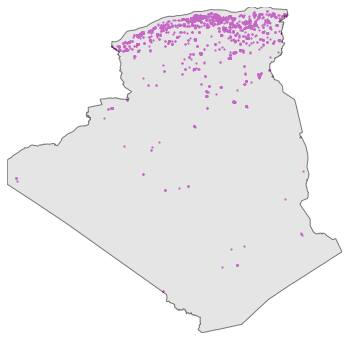

In [369]:
west, south, east, north = gdf.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)

ax.scatter(x=point_gdf['x'], y=point_gdf['y'], s=5, c='m', linewidth=0, zorder=1)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

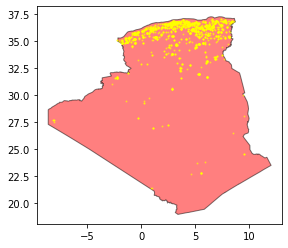

In [370]:
ax = gdf.plot(color='red', edgecolor='black', alpha=0.5)
ax = point_gdf.plot(ax=ax, color='yellow', markersize=1, alpha=0.5)

In [371]:
sp_index = point_gdf.sindex

In [372]:
list_k_nearest = list(sp_index.nearest((poi.y, poi.y, poi.x, poi.x), 5))

In [376]:
m = folium.Map(
    location=[point_gdf.iloc[list_k_nearest[0]].y, point_gdf.iloc[list_k_nearest[0]].x],
    zoom_start=4,
    tiles='Stamen Terrain'
)

five_nearest = []
for i in range(point_gdf.shape[0]):
    if i in list_k_nearest:
        add = {
            'x': point_gdf.iloc[i]['x'],
            'y': point_gdf.iloc[i]['y'],
            'geometry': point_gdf.iloc[i]['geometry']
        }
        folium.Marker([point_gdf.iloc[i]['y'], point_gdf.iloc[i]['x']], popup='<i>RESULT</i>', tooltip=tooltip, icon=folium.Icon(color='red')).add_to(m)
        five_nearest.append(add)

five_nearest_gdf = gpd.GeoDataFrame(five_nearest)

<AxesSubplot:>

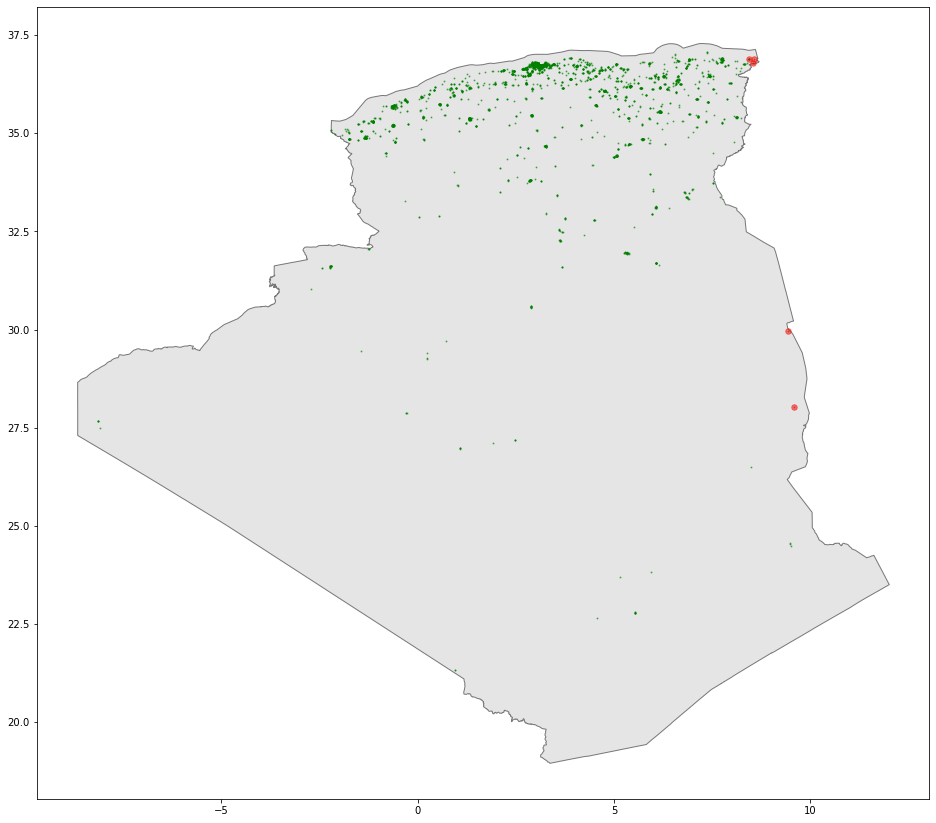

In [374]:
fig, ax = plt.subplots(figsize=(16,16))
gdf.plot(ax = ax, color='#cccccc', edgecolor='black', alpha=0.5)
point_gdf.plot(ax=ax, color='green', markersize=1, alpha=0.5)
five_nearest_gdf.plot(ax=ax, color='red', markersize=30, alpha=0.5)

In [377]:
m

Пункт 3

In [12]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
# poly = world[world['CODE']=='AFG'].loc[103]['geometry']
world[['name', 'geometry']]

,name,geometry
0,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,Tanzania,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,W. Sahara,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...
172,Serbia,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,Montenegro,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,Kosovo,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,Trinidad and Tobago,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [69]:
re_c = []
for i in range(world.shape[0]):
    type_ = type(world.loc[i, 'geometry'])
    if type_ == type(world.loc[0, 'geometry']):
#         print('!')
        min_coord = 90
        max_coord = -90
        min_dolg = 180
        max_dolg = -180
        for item in world.loc[i, 'geometry']:
            bounds = item.bounds
            if bounds[1] < min_coord:
                min_coord = bounds[1]
            if bounds[3] > max_coord:
                max_coord = bounds[3]
        for item in world.loc[i, 'geometry']:
            for point in item.exterior.coords:
                if point[1] == min_coord:
                    min_dolg = point[0]
                if point[1] == max_coord:
                    max_dolg = point[0]
    else:
#         print(world.loc[i, 'name'])
        bounds = world.loc[i, 'geometry'].bounds
        min_coord = bounds[1]
        max_coord = bounds[3]
        min_dolg = 180
        max_dolg = -180
        for point in world.loc[i, 'geometry'].exterior.coords:
#             print(min_coord, max_coord, point)
            if point[1] == min_coord:
                min_dolg = point[0]
            if point[1] == max_coord:
                max_dolg = point[0]
    add = {
        'country': world.loc[i]['name'],
        'min_sh': min_coord,
        'max_sh': max_coord,
        'min_dolg': min_dolg,
        'max_dolg': max_dolg
    }
    re_c.append(add)

In [71]:
for item in re_c:
    if item['country'] != 'Fiji':
        item['a'] = (item['max_sh'] - item['min_sh']) / (item['max_dolg'] - item['min_dolg'])
        item['mid_x'] = (item['max_dolg'] + item['min_dolg']) / 2
        item['mid_y'] = (item['max_sh'] + item['min_sh']) / 2
        item['a2'] = - 1 / item['a']
        item['b2'] = item['mid_y'] - item['a2'] * item['mid_x']


In [108]:
import requests
import json
overpass_url = "http://overpass-api.de/api/interpreter"

re_3 = []
# for ind in range(world.shape[0]):
ind = 3
contry_code = df_c.loc[ind, 'CODE']
if ind != 0 and contry_code != '-1':
    overpass_query = """
    [out:json];
    area["ISO3166-1:alpha3"=""" + contry_code + """][admin_level=2];
    (node["highway"="bus_stop"](area);
    );
    out center;
    """
    response = requests.get(overpass_url, 
                            params={'data': overpass_query})
    data = response.json()['elements']
    bus_stops_counts = len([x for x in data if re_c[ind]['b2'] + x['lat'] * re_c[ind]['a2'] > x['lon']])
    overpass_query = """
    [out:json];
    area["ISO3166-1:alpha3"=""" + contry_code + """][admin_level=2];
    (node["railway"="station"](area);
    );
    out center;
    """
    response = requests.get(overpass_url, 
                            params={'data': overpass_query})
    data = response.json()['elements']
    railways_counts = len([x for x in data if re_c[ind]['b2'] + x['lat'] * re_c[ind]['a2'] > x['lon']])
    add = {
        'ind': ind,
        'country': world.loc[ind, 'name'],
        'bus': bus_stops_counts,
        'rail': railways_counts,
        'otn': bus_stops_counts / railways_counts if railways_counts else bus_stops_counts
    }
    re_3.append(add)
    print(world.loc[ind, 'name'], add['otn'])

Canada 0.0


In [212]:
count_re_ = []
overpass = Overpass()
for ind in range(df_c.shape[0]):
    capital = df_c.loc[ind, 'mapped']
    if type(capital) == type('1'):
        if capital == 'Mexico City, Mexico':
            capital = 'Mexico, Mexico'
        areaId = nominatim.query(capital).areaId()
        print(capital, areaId)
        if areaId:
            query = overpassQueryBuilder(area=areaId, elementType=['node'], selector='"highway"="bus_stop"', out='body', includeGeometry=True)
            response = overpass.query(query, timeout = 1000)
            data = response.elements()
            bus_stops_counts = len([x for x in data if re_c[ind]['b2'] + float(x.lat()) * re_c[ind]['a2'] > float(x.lon())])
            query = overpassQueryBuilder(area=areaId, elementType=['node'], selector='"railway"="station"', out='body', includeGeometry=True)
            response = overpass.query(query, timeout = 1000)
            data = response.elements()
            railway_stops_counts = len([x for x in data if re_c[ind]['b2'] + float(x.lat()) * re_c[ind]['a2'] > float(x.lon())])
            add = {
                'capital': capital,
                'bus_stops': bus_stops_counts,
                'railway_stops_counts': railway_stops_counts
            }
            count_re_.append(add)

Suva, Fiji None
Dodoma, Tanzania 3601600774
[overpass] downloading data: [timeout:1000][out:json];area(3601600774)->.searchArea;(node["railway"="station"](area.searchArea);); out body geom;
Ottawa, Canada 3604136816
[overpass] downloading data: [timeout:1000][out:json];area(3604136816)->.searchArea;(node["railway"="station"](area.searchArea);); out body geom;
Astana, Kazakhstan 3603087156
[overpass] downloading data: [timeout:1000][out:json];area(3603087156)->.searchArea;(node["railway"="station"](area.searchArea);); out body geom;
Tashkent, Uzbekistan 3602216724
[overpass] downloading data: [timeout:1000][out:json];area(3602216724)->.searchArea;(node["railway"="station"](area.searchArea);); out body geom;
Port Moresby, Papua New Guinea None
Jakarta, Indonesia 3606362934
[overpass] downloading data: [timeout:1000][out:json];area(3606362934)->.searchArea;(node["railway"="station"](area.searchArea);); out body geom;
Buenos Aires, Argentina 3601224652
[overpass] downloading data: [timeout

Libreville, Gabon 3602804109
[overpass] downloading data: [timeout:1000][out:json];area(3602804109)->.searchArea;(node["railway"="station"](area.searchArea);); out body geom;
Lusaka, Zambia None
Lilongwe, Malawi 3607345524
[overpass] downloading data: [timeout:1000][out:json];area(3607345524)->.searchArea;(node["railway"="station"](area.searchArea);); out body geom;
Maputo, Mozambique 3603348644
[overpass] downloading data: [timeout:1000][out:json];area(3603348644)->.searchArea;(node["railway"="station"](area.searchArea);); out body geom;
Luanda, Angola 3601802546
[overpass] downloading data: [timeout:1000][out:json];area(3601802546)->.searchArea;(node["railway"="station"](area.searchArea);); out body geom;
Bujumbura, Burundi None
Jerusalem, Israel 3601381350
[overpass] downloading data: [timeout:1000][out:json];area(3601381350)->.searchArea;(node["railway"="station"](area.searchArea);); out body geom;
Beirut, Lebanon 3605466662
[overpass] downloading data: [timeout:1000][out:json];are

Zagreb, Croatia 3603168167
[overpass] downloading data: [timeout:1000][out:json];area(3603168167)->.searchArea;(node["railway"="station"](area.searchArea);); out body geom;
Bern, Switzerland 3601682378
[overpass] downloading data: [timeout:1000][out:json];area(3601682378)->.searchArea;(node["railway"="station"](area.searchArea);); out body geom;
Luxembourg, Luxembourg 3600407489
[overpass] downloading data: [timeout:1000][out:json];area(3600407489)->.searchArea;(node["railway"="station"](area.searchArea);); out body geom;
Brussels, Belgium 3602404021
[overpass] downloading data: [timeout:1000][out:json];area(3602404021)->.searchArea;(node["railway"="station"](area.searchArea);); out body geom;
Amsterdam, Netherlands 3600271110
[overpass] downloading data: [timeout:1000][out:json];area(3600271110)->.searchArea;(node["railway"="station"](area.searchArea);); out body geom;
Lisbon, Portugal 3605400890
[overpass] downloading data: [timeout:1000][out:json];area(3605400890)->.searchArea;(node

In [168]:
df_c = world.merge(capitals, how = 'left', left_on = 'name', right_on = 'country')

In [213]:
for item in count_re_:
    item['otn'] = item['bus_stops'] / item['railway_stops_counts'] if item['railway_stops_counts'] else item['bus_stops']

In [217]:
sorted(filter(lambda x: x['otn'] > 0, count_re_), key=lambda x: x['otn'])

[{'capital': 'Cairo, Egypt',
  'bus_stops': 31,
  'railway_stops_counts': 59,
  'otn': 0.5254237288135594},
 {'capital': 'Porto-Novo, Benin',
  'bus_stops': 1,
  'railway_stops_counts': 1,
  'otn': 1.0},
 {'capital': 'Tunis, Tunisia',
  'bus_stops': 724,
  'railway_stops_counts': 212,
  'otn': 3.4150943396226414},
 {'capital': 'Sofia, Bulgaria',
  'bus_stops': 146,
  'railway_stops_counts': 39,
  'otn': 3.7435897435897436},
 {'capital': 'Nouakchott, Mauritania',
  'bus_stops': 5,
  'railway_stops_counts': 0,
  'otn': 5},
 {'capital': 'Brussels, Belgium',
  'bus_stops': 190,
  'railway_stops_counts': 22,
  'otn': 8.636363636363637},
 {'capital': 'Ankara, Turkey',
  'bus_stops': 840,
  'railway_stops_counts': 88,
  'otn': 9.545454545454545},
 {'capital': 'Niamey, Niger',
  'bus_stops': 13,
  'railway_stops_counts': 1,
  'otn': 13.0},
 {'capital': 'Caracas, Venezuela',
  'bus_stops': 647,
  'railway_stops_counts': 45,
  'otn': 14.377777777777778},
 {'capital': 'Georgetown, Guyana',
  'bus

Таким образом, наибольшее отношение числа железнодорожных станций к автобусным остановкам в южной части достигается в Каире в Египте. (Здесь я опять же рассматривал столицы государств, чтобы это все вообще посчиталось)

In [378]:
import requests
import json
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="EG"][admin_level=2];
(node["amenity"="cinema"](area);
);
out center;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()
len(data['elements'])

47

In [380]:
cinema_data = []
for point in data['elements']:
    add = {
        'x': point['lon'],
        'y': point['lat'],
        'geometry': Point(point['lon'], point['lat'])
    }
    cinema_data.append(add)

In [382]:
gdf = ox.geocode_to_gdf('Egypt')
geometry = gdf['geometry'].iloc[0]
point_gdf = gpd.GeoDataFrame(cinema_data)
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])

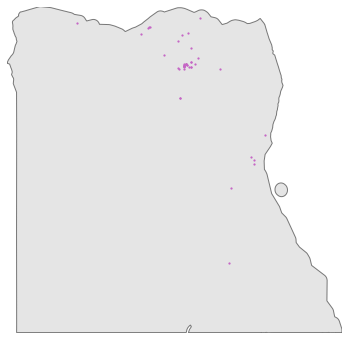

In [383]:
west, south, east, north = gdf.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)

ax.scatter(x=point_gdf['x'], y=point_gdf['y'], s=5, c='m', linewidth=0, zorder=1)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [384]:
sp_index = point_gdf.sindex
list_k_nearest = list(sp_index.nearest((poi.y, poi.y, poi.x, poi.x), 5))

In [385]:
m = folium.Map(
    location=[point_gdf.iloc[list_k_nearest[0]].y, point_gdf.iloc[list_k_nearest[0]].x],
    zoom_start=4,
    tiles='Stamen Terrain'
)

five_nearest = []
for i in range(point_gdf.shape[0]):
    if i in list_k_nearest:
        add = {
            'x': point_gdf.iloc[i]['x'],
            'y': point_gdf.iloc[i]['y'],
            'geometry': point_gdf.iloc[i]['geometry']
        }
        folium.Marker([point_gdf.iloc[i]['y'], point_gdf.iloc[i]['x']], popup='<i>RESULT</i>', tooltip=tooltip, icon=folium.Icon(color='red')).add_to(m)
        five_nearest.append(add)

five_nearest_gdf = gpd.GeoDataFrame(five_nearest)

<AxesSubplot:>

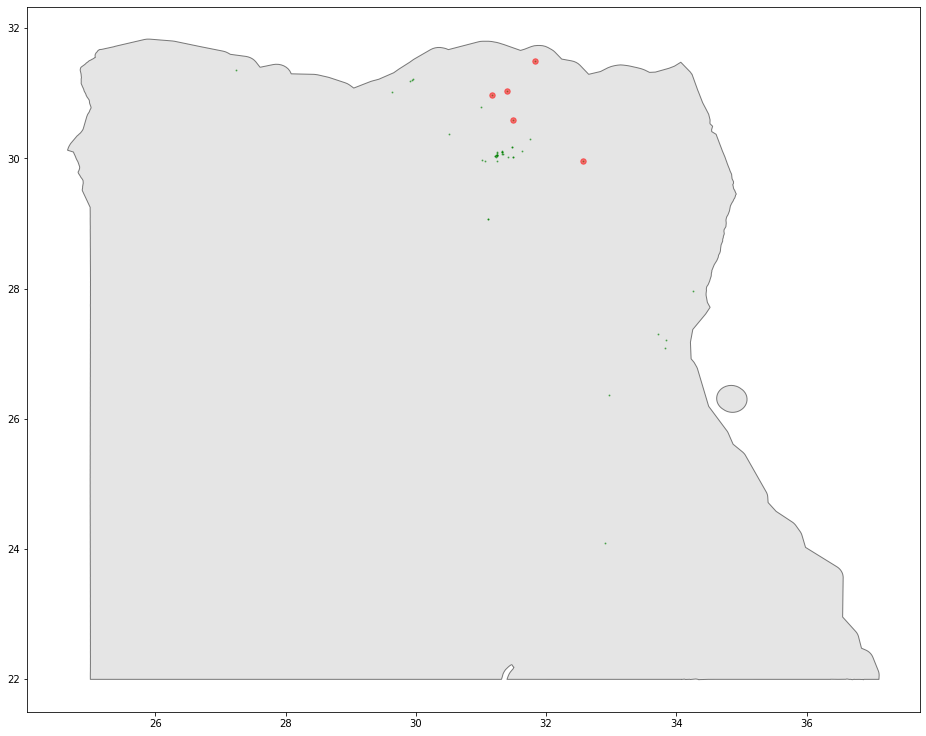

In [386]:
fig, ax = plt.subplots(figsize=(16,16))
gdf.plot(ax = ax, color='#cccccc', edgecolor='black', alpha=0.5)
point_gdf.plot(ax=ax, color='green', markersize=1, alpha=0.5)
five_nearest_gdf.plot(ax=ax, color='red', markersize=30, alpha=0.5)

In [387]:
m

## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [1]:
# put your code here
import json
import requests

import folium
import pyproj
from shapely import geometry
from shapely.geometry import Point, LineString, Polygon, MultiPolygon

from openrouteservice import client

In [2]:
url = 'https://data.cityofnewyork.us/api/views/a3nt-yts4/rows.json?accessType=DOWNLOAD'

def CreateBufferPolygon(point_in, resolution=10, radius=10):    

    sr_wgs = pyproj.Proj(init='epsg:4326')
    sr_utm = pyproj.Proj(init='epsg:32632') # WGS84 UTM32N
    point_in_proj = pyproj.transform(sr_wgs, sr_utm, *point_in) # unpack list to arguments
    point_buffer_proj = Point(point_in_proj).buffer(radius, resolution=resolution) # 10 m buffer
    
    # Iterate over all points in buffer and build polygon
    poly_wgs = []
    for point in point_buffer_proj.exterior.coords:
        poly_wgs.append(pyproj.transform(sr_utm, sr_wgs, *point)) # Transform back to WGS84

    return poly_wgs

In [43]:
api_key = '5b3ce3597851110001cf624882d7c0703dd14fadb02e5325d12934b3' # Individual api key
clnt = client.Client(key=api_key) # Create client with api key
rostock_json = requests.get(url).json() # Get data as JSON

map_params = {'tiles':'Stamen Toner',
              'location':([40.13207, -73.101612]),
              'zoom_start': 12}
map1 = folium.Map(**map_params)

# Populate a construction site buffer polygon list
sites_poly = []
for site_data in df['geometry']:
    site_coords = site_data #site_data['geometry']['coordinates']
    
    folium.Marker([site_coords.y, site_coords.x],
                           popup='Construction point<br>{0}'.format(site_coords)).add_to(map1)
    
    # Create buffer polygons around construction sites with 10 m radius and low resolution
    site_poly_coords = site_coords.buffer(10, resolution=2)
    sites_poly.append(site_poly_coords)
    
#     site_poly_coords = list(df['geometry']) # [(y,x) for x,y in site_coords] # Reverse coords for folium/Leaflet
#     folium.vector_layers.Polygon(locations=site_poly_coords,
#                                   color='#ffd699',
#                                   fill_color='#ffd699',
#                                   fill_opacity=0.2,
#                                   weight=3).add_to(map1)
    
map1

In [9]:
list_of_schools = [x[8] for x in rostock_json['data']]

In [17]:
import pandas as pd
from shapely import wkt
df = pd.DataFrame(list_of_schools)
df['geometry'] = df[0].apply(wkt.loads)

In [ ]:
sites_poly = []
for site_data in df['geometry']:
    site_poly_coords = site_data.buffer(0.0005, resolution=2)
    sites_poly.append(site_poly_coords)
#     print(site_data)

In [110]:
def style_function(color):
    return lambda feature: dict(color=color,
                              weight=3,
                              opacity=0.5)

# Create new map to start from scratch
map_params.update({'location': ([40.788689, -73.955219]),
                   'zoom_start': 12})
map2 = folium.Map(**map_params)

# Request normal route between appropriate locations without construction sites
request_params = {'coordinates': [[-73.955219, 40.788689],
                                 [-73.989573, 40.703165]],
                'format_out': 'geojson',
                'profile': 'driving-car',
                'preference': 'shortest',
                'instructions': 'false',}
route_normal = clnt.directions(**request_params)
folium.features.GeoJson(data=route_normal,
                        name='Route without construction sites',
                        style_function=style_function('#FF0000'),
                        overlay=True).add_to(map2)

# Buffer route with 0.009 degrees (really, just too lazy to project again...)
route_buffer = LineString(route_normal['features'][0]['geometry']['coordinates']).buffer(0.009)
folium.features.GeoJson(data=geometry.mapping(route_buffer),
                        name='Route Buffer',
                        style_function=style_function('#FFFF00'),
                        overlay=True).add_to(map2)

# # Plot which construction sites fall into the buffer Polygon
sites_buffer_poly = []
for site_poly in sites_poly:
    poly = Polygon(site_poly)
#     poly = site_poly
#     print(poly.centroid.coords[0])
    if route_buffer.intersects(poly):
        folium.features.Marker(list(reversed(poly.centroid.coords[0]))).add_to(map2)
        sites_buffer_poly.append(poly)

map2

In [111]:
request_params = {'coordinates': [[-73.955219, 40.788689],
                                 [-73.989573, 40.703165]],
                'format_out': 'geojson',
                'profile': 'driving-car',
                'preference': 'shortest',
                'instructions': 'false',}
request_params['options'] = {'avoid_polygons': geometry.mapping(MultiPolygon(sites_buffer_poly))}
route_detour = clnt.directions(**request_params)

folium.features.GeoJson(data=route_detour,
                        name='Route with construction sites',
                        style_function=style_function('#00FF00'),
                        overlay=True).add_to(map2)

map2.add_child(folium.map.LayerControl())
map2

In [112]:
# request_params['options']['avoid_polygons']['coordinates']